### Cab-Driver Agent

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import random
import math
import itertools
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

%matplotlib inline

from Env import CabDriver

#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

# checking shape of Time_matrix
print('Time matrix shape: ', Time_matrix.shape)

Time matrix shape:  (5, 5, 24, 7)


**Observation:** <br>
**5** start location <br>
**5** end location <br>
**24** hours of day <br>
**7** days of week

In [3]:
# random sample
Time_matrix[1][2][10][5]

11.0

**Observation:** Trip time is **11 hours**

In [4]:
# Time matrix analysis min
print('Time matrix min: ', Time_matrix.min())

# Time matrix analysis max
print ('Time matrix max: ', Time_matrix.max())

Time matrix min:  0.0
Time matrix max:  11.0


**Observation:** A trip can be of 0-11 hours

In [5]:
# Time matrix analysis median
np.median(Time_matrix)

2.5

**Observation:** A typical trip is 2.5 hours

In [6]:
# Time matrix analysis mean
Time_matrix.mean()

3.0542857142857143

**Observation:** Mean trip time is 3 hours

#### Tracking the state-action pairs for checking convergence


In [7]:
env = CabDriver()
# Check requests
actions = env.requests(env.state_init)

# Select a random action
rand_action = random.choice(actions)
print('Selection action : ', rand_action)
print()

# Check next_state, and reward from random action
next_state, reward, is_terminal = env.step_func(env.state_init, rand_action)

print('Reward: ', reward, ' Next state: ', next_state, ' Is terminal: ', is_terminal)
print('Tracked data: ', env.tracked_data())
print()

# Check next_state, and reward if driver did not take any requests
next_state, reward, is_terminal = env.step_func(env.state_init,(0,0))
print('Reward: ', reward, ' Next state: ', next_state, ' Is terminal: ', is_terminal)
print('Tracked data: ', env.tracked_data())
print()

encoded_state = env.encode_state(env.state_init)
print('Encoded state: ', encoded_state.shape)

Selection action :  (1, 2)

Reward:  -6  Next state:  (2, 12, 6)  Is terminal:  False
Tracked data:  (-6, 12, 1)

Reward:  -5  Next state:  (4, 1, 6)  Is terminal:  False
Tracked data:  (-11, 14, 2)

Encoded state:  (36,)


In [8]:
epi_num = []
epi_reward = []
epi_time = []
epi_trips = []
max_epi = 100

env=CabDriver()

for epi in range(1, max_epi+1):
    env.reset()
    state = env.state_init
    is_terminal = False
    while not is_terminal:
        # random action selection
        actions = env.requests(state)
        action = random.choice(actions)
        next_state, reward, is_terminal = env.step_func(state, action)
        state = next_state
    
    reward, time, trips = env.tracked_data()
    epi_num.append(epi)
    epi_reward.append(reward)
    epi_time.append(time)
    epi_trips.append(trips)
    
epi_df=pd.DataFrame(data={'num':epi_num,'reward':epi_reward,'time':epi_time,'trips':epi_trips})

In [9]:
epi_df.describe()

,num,reward,time,trips
count,100.000000,100.000000,100.000000,100.000000
mean,50.500000,-126.150000,724.410000,127.760000
std,29.011492,175.772717,3.760762,7.929131
min,1.000000,-526.000000,720.000000,111.000000
25%,25.750000,-245.250000,721.750000,121.750000
50%,50.500000,-131.000000,723.000000,128.000000
75%,75.250000,-1.500000,727.000000,133.250000
max,100.000000,380.000000,735.000000,156.000000


<AxesSubplot:xlabel='num'>

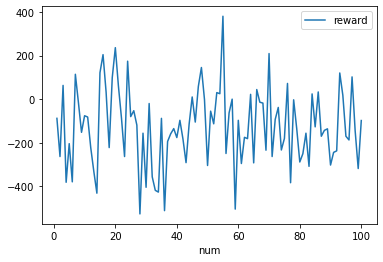

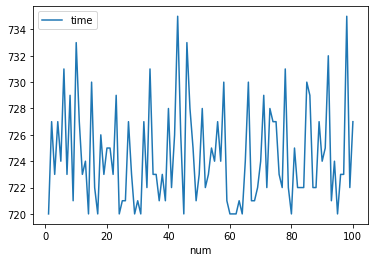

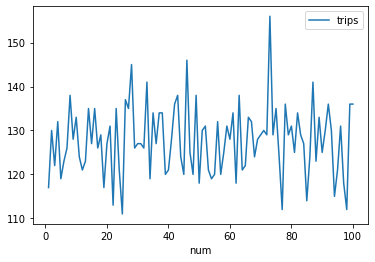

In [10]:
# Plot epi vs tracked data
epi_df.plot(x='num',y='reward')
epi_df.plot(x='num',y='time')
epi_df.plot(x='num',y='trips')

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state-action and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [41]:
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [46]:
class DQNAgent:
    def __init__(self, state_size=None, action_size=None, discount_factor=0.95, learning_rate=0.01, epsilon_min=0., epsilon_max=1., epsilon_decay=-0.0001, batch_size=32, experience_buffer_size=2000, env=CabDriver(), state_encoding='v1'):
        # Define size of state and action
        
        if state_size is not None:
            self.state_size = state_size
        else:
            self.state_size = env.state_size

        if action_size is not None:
            self.action_size = action_size
        else:
            self.action_size = len(env.action_space)

        self.state_encoding = state_encoding
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate 
        self.epsilon_min = epsilon_min
        self.epsilon_max = epsilon_max
        self.epsilon = epsilon_max
        self.epsilon_decay = epsilon_decay
        self.trip = 0
        
        self.batch_size = batch_size        
        # create replay memory using deque
        self.memory = deque(maxlen=experience_buffer_size)
        
        self.env = env
        
        # create main model and target model
        self.model = self.build_model()
        self.target_model = self.build_model()
        
        # initialize target model
        self.update_target_model()

    # approximate Q function using Neural Network
    def build_model(self):

        model = Sequential()

        # hidden layers
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))

        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))

        return model

    # after some time interval update the target model to be same with model
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def get_action(self, state):
        """
        get action in a state according to an epsilon-greedy approach
        """
        if np.random.rand() <= self.epsilon:
            # random action selection
            actions = self.env.requests(state)
            action = random.choice(actions)
        else:
            # choose the action with the highest q(s, a)
            encoded_state = self.env.encode_state(state)
            # the first index corresponds to the batch size, so reshape state to (1, state_size) so that the first index corresponds to the batch size
            encoded_state = encoded_state.reshape(1, self.state_size)
            q_value = self.model.predict(encoded_state)
            action = self.env.action_space[np.argmax(q_value[0])]

        return action
      
    def get_q_value(self, state, action):
        encoded_state = self.env.encode_state(state)
        encoded_state = encoded_state.reshape(1, self.state_size)
        q_value = self.model.predict(encoded_state)
        action_index = self.env.action_space.index(action)
        return q_value[0][action_index]

    def append_sample(self, state, action, reward, next_state, is_terminal):
        self.memory.append((state, action, reward, next_state, is_terminal))
        
    def decay_epsilon(self):
        # Decay in ε after we generate each sample from the environment       
        self.trip = self.trip + 1
        self.epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(self.epsilon_decay * self.trip)
   
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        """
        train the neural network on a minibatch. Input to the network is the states,
        output is the target q-value corresponding to each action.
        """
        if len(self.memory) >= self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            
            update_input = np.zeros((self.batch_size, self.state_size))
            update_target = np.zeros((self.batch_size, self.state_size))
            action, reward, is_terminal = [], [], []
            
            for i in range(self.batch_size):
                update_input[i] = self.env.encode_state(mini_batch[i][0])
                update_target[i] = self.env.encode_state(mini_batch[i][3])
                action.append(mini_batch[i][1])
                reward.append(mini_batch[i][2])
                is_terminal.append(mini_batch[i][4])
 
            # predict the target q-values from states s
            target = self.model.predict(update_input)

            # target for q-network
            target_qval = self.target_model.predict(update_target)

            # update the target values
            for i in range(self.batch_size):
                action_index = self.env.action_space.index(action[i])
                if is_terminal[i]:
                    target[i][action_index] = reward[i]
                else:
                    target[i][action_index] = reward[i] + self.discount_factor * (np.amax(target_qval[i]))

            # model fit
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)

    def save(self, name):
        self.model.save(name + '.hd5')
        weights = self.model.get_weights()   # Gets model_weights as a list of numpy arrays
        try:
            fpkl = open(name + '.pkl', 'wb')
            pickle.dump(weights, fpkl, protocol= pickle.HIGHEST_PROTOCOL)  
            fpkl.close()
        except Exception as e:
            print(e)

### DQN block

In [44]:
rewards, trips, times, episodes = [], [], [], []
samples = {}

def train_agent(max_epi=100, model_name='model', print_epi=10, save_epi=100, **agent_args):
    env = CabDriver()
    agent = DQNAgent(**agent_args)
    
    # randomly sample 2 of state-action pairs for tracking convergence
    to_sample = random.sample([(state,action) for state,action in itertools.product(env.state_space, env.action_space)], 10)
    for state,action in to_sample:
        samples.update({(state,action):[]})

    for epi in range(max_epi):    
        is_terminal = False
        reward = 0
        state = env.reset()
        rewards_arr = []

        while not is_terminal:
            # Write your code here
            # 1. Pick epsilon-greedy action from possible actions for the current state
            # 2. Evaluate your reward and next state
            # 3. Append the experience to the memory
            # 4. Train the model by calling function agent.train_model
            # 5. Keep a track of rewards, Q-values, loss

            # get action for the current state and go one step in environment
            action = agent.get_action(state)
            next_state, reward, is_terminal = env.step_func(state, action)
            rewards_arr.append(reward)
            agent.append_sample(state, action, reward, next_state, is_terminal)
            agent.decay_epsilon()
            agent.train_model()
            
            if (state,action) in to_sample:
                q_value = agent.get_q_value(state, action)
                samples[(state,action)].append(q_value)

            state = next_state

        agent.update_target_model()
        epi_reward, epi_time, epi_trips = env.tracked_data()
        rewards.append(epi_reward)
        trips.append(epi_trips)
        times.append(epi_time)
        episodes.append(epi)

        if (epi % print_epi == 0)  | (epi == max_epi-1):
            print("Episode:", epi, "  Reward:", epi_reward, "  Trips:", epi_trips, " Time:", epi_time, "  Memory:", len(agent.memory), "  Total trips:", agent.trip, "  Epsilon:", agent.epsilon)

        if epi % save_epi == 0:
            agent.save(model_name)

    agent.save(model_name)
    return agent

In [16]:
rewards, trips, times, episodes = [], [], [], []
samples = {}
train_agent(max_epi=1, model_name='test.hd5', epsilon_decay=-0.00005)

Episode: 0   Reward: -157   Trips: 130  Time: 725   Memory: 130   Total trips: 130   Epsilon: 0.9935210793034477
INFO:tensorflow:Assets written to: test.hd5\assets
INFO:tensorflow:Assets written to: test.hd5\assets


In [17]:
rewards, trips, times, episodes = [], [], [], []
samples = {}
train_agent(max_epi=50, model_name='model_0.hd5', epsilon_decay=-0.0005)

Episode: 0   Reward: -441   Trips: 125  Time: 725   Memory: 125   Total trips: 125   Epsilon: 0.9394130628134758
INFO:tensorflow:Assets written to: model_0.hd5\assets
Episode: 10   Reward: 1072   Trips: 117  Time: 723   Memory: 1351   Total trips: 1351   Epsilon: 0.5089019060311919
Episode: 20   Reward: 1099   Trips: 105  Time: 726   Memory: 2000   Total trips: 2469   Epsilon: 0.29098021610944064
Episode: 30   Reward: 1546   Trips: 103  Time: 721   Memory: 2000   Total trips: 3563   Epsilon: 0.16838537967078487
Episode: 40   Reward: 1638   Trips: 102  Time: 721   Memory: 2000   Total trips: 4652   Epsilon: 0.09768570948272756
Episode: 49   Reward: 1775   Trips: 100  Time: 720   Memory: 2000   Total trips: 5631   Epsilon: 0.0598747738675841
INFO:tensorflow:Assets written to: model_0.hd5\assets


In [18]:
rewards, trips, times, episodes = [], [], [], []
samples = {}
train_agent(max_epi=50, model_name='model_1.hd5', epsilon_decay=-0.0001)

Episode: 0   Reward: -217   Trips: 128  Time: 730   Memory: 128   Total trips: 128   Epsilon: 0.9872815715902905
INFO:tensorflow:Assets written to: model_1.hd5\assets
Episode: 10   Reward: 105   Trips: 122  Time: 720   Memory: 1403   Total trips: 1403   Epsilon: 0.8690974670453949
Episode: 20   Reward: -37   Trips: 121  Time: 722   Memory: 2000   Total trips: 2658   Epsilon: 0.7665924306563239
Episode: 30   Reward: 83   Trips: 119  Time: 729   Memory: 2000   Total trips: 3885   Epsilon: 0.6780732218798831
Episode: 40   Reward: 208   Trips: 127  Time: 725   Memory: 2000   Total trips: 5104   Epsilon: 0.6002554286139826
Episode: 49   Reward: 413   Trips: 111  Time: 720   Memory: 2000   Total trips: 6187   Epsilon: 0.5386442201236387
INFO:tensorflow:Assets written to: model_1.hd5\assets


In [19]:
rewards, trips, times, episodes = [], [], [], []
samples = {}
train_agent(max_epi=50, model_name='model_2.hd5', epsilon_max=1.0, epsilon_decay=-0.0001, epsilon_min=0.0)

Episode: 0   Reward: -217   Trips: 133  Time: 720   Memory: 133   Total trips: 133   Epsilon: 0.9867880541941261
INFO:tensorflow:Assets written to: model_2.hd5\assets
Episode: 10   Reward: 214   Trips: 124  Time: 720   Memory: 1378   Total trips: 1378   Epsilon: 0.8712729289072828
Episode: 20   Reward: 155   Trips: 114  Time: 723   Memory: 2000   Total trips: 2607   Epsilon: 0.7705120385570716
Episode: 30   Reward: 90   Trips: 130  Time: 728   Memory: 2000   Total trips: 3840   Epsilon: 0.6811314271795471
Episode: 40   Reward: 311   Trips: 121  Time: 723   Memory: 2000   Total trips: 5090   Epsilon: 0.6010963747389753
Episode: 49   Reward: 561   Trips: 124  Time: 723   Memory: 2000   Total trips: 6214   Epsilon: 0.537191842321657
INFO:tensorflow:Assets written to: model_2.hd5\assets


In [20]:
rewards, trips, times, episodes = [], [], [], []
samples = {}
train_agent(max_epi=50, model_name='model_3.hd5', learning_rate=0.01, epsilon_max=1.0, epsilon_decay=-0.0001, epsilon_min=0.0)

Episode: 0   Reward: 85   Trips: 135  Time: 721   Memory: 135   Total trips: 135   Epsilon: 0.9865907163177327
INFO:tensorflow:Assets written to: model_3.hd5\assets
Episode: 10   Reward: 120   Trips: 131  Time: 720   Memory: 1357   Total trips: 1357   Epsilon: 0.8731045245603125
Episode: 20   Reward: -279   Trips: 122  Time: 727   Memory: 2000   Total trips: 2595   Epsilon: 0.7714372079939819
Episode: 30   Reward: 283   Trips: 115  Time: 724   Memory: 2000   Total trips: 3808   Epsilon: 0.6833145388622924
Episode: 40   Reward: 266   Trips: 102  Time: 725   Memory: 2000   Total trips: 4954   Epsilon: 0.6093271276925619
Episode: 49   Reward: 469   Trips: 125  Time: 724   Memory: 2000   Total trips: 6024   Epsilon: 0.547496067481209
INFO:tensorflow:Assets written to: model_3.hd5\assets


In [21]:
rewards, trips, times, episodes = [], [], [], []
samples = {}
train_agent(max_epi=50, model_name='model_4.hd5', discount_factor=0.95, learning_rate=0.01, epsilon_max=1.0, epsilon_decay=-0.0001, epsilon_min=0.0)

Episode: 0   Reward: -335   Trips: 131  Time: 726   Memory: 131   Total trips: 131   Epsilon: 0.9869854315420418
INFO:tensorflow:Assets written to: model_4.hd5\assets
Episode: 10   Reward: 267   Trips: 123  Time: 720   Memory: 1363   Total trips: 1363   Epsilon: 0.8725808189729637
Episode: 20   Reward: 214   Trips: 140  Time: 726   Memory: 2000   Total trips: 2596   Epsilon: 0.7713600681302399
Episode: 30   Reward: 489   Trips: 114  Time: 721   Memory: 2000   Total trips: 3828   Epsilon: 0.6819492755030149
Episode: 40   Reward: 416   Trips: 109  Time: 720   Memory: 2000   Total trips: 5034   Epsilon: 0.6044719572470183
Episode: 49   Reward: 661   Trips: 121  Time: 723   Memory: 2000   Total trips: 6139   Epsilon: 0.5412359275018637
INFO:tensorflow:Assets written to: model_4.hd5\assets


In [22]:
rewards, trips, times, episodes = [], [], [], []
samples = {}
train_agent(max_epi=50, model_name='model_5.hd5', learning_rate=0.005, epsilon_max=1.0, epsilon_decay=-0.0001, epsilon_min=0.0)

Episode: 0   Reward: 2   Trips: 127  Time: 722   Memory: 127   Total trips: 127   Epsilon: 0.9873803046840219
INFO:tensorflow:Assets written to: model_5.hd5\assets
Episode: 10   Reward: 187   Trips: 145  Time: 720   Memory: 1395   Total trips: 1395   Epsilon: 0.8697930232043986
Episode: 20   Reward: 330   Trips: 121  Time: 723   Memory: 2000   Total trips: 2589   Epsilon: 0.7719002092052516
Episode: 30   Reward: 390   Trips: 106  Time: 721   Memory: 2000   Total trips: 3792   Epsilon: 0.6844087172337445
Episode: 40   Reward: 392   Trips: 123  Time: 723   Memory: 2000   Total trips: 5013   Epsilon: 0.6057426821513953
Episode: 49   Reward: 534   Trips: 118  Time: 727   Memory: 2000   Total trips: 6096   Epsilon: 0.5435682528959954
INFO:tensorflow:Assets written to: model_5.hd5\assets


In [23]:
rewards, trips, times, episodes = [], [], [], []
samples = {}
train_agent(max_epi=50, model_name='model_6.hd5', learning_rate=0.0005, epsilon_max=1.0, epsilon_decay=-0.00005, epsilon_min=0.0)

Episode: 0   Reward: -223   Trips: 122  Time: 722   Memory: 122   Total trips: 122   Epsilon: 0.993918567227454
INFO:tensorflow:Assets written to: model_6.hd5\assets
Episode: 10   Reward: 137   Trips: 132  Time: 722   Memory: 1381   Total trips: 1381   Epsilon: 0.933280014910837
Episode: 20   Reward: 15   Trips: 129  Time: 733   Memory: 2000   Total trips: 2667   Epsilon: 0.8751587329425146
Episode: 30   Reward: 75   Trips: 125  Time: 720   Memory: 2000   Total trips: 3890   Epsilon: 0.8232461782565231
Episode: 40   Reward: 310   Trips: 114  Time: 722   Memory: 2000   Total trips: 5104   Epsilon: 0.7747615301587855
Episode: 49   Reward: 680   Trips: 125  Time: 730   Memory: 2000   Total trips: 6188   Epsilon: 0.733887156444884
INFO:tensorflow:Assets written to: model_6.hd5\assets


In [47]:
rewards, trips, times, episodes = [], [], [], []
samples = {}
final_agent = train_agent(max_epi=200, print_epi=20, save_epi=20, model_name='model_final', epsilon_decay=-0.0005)

Episode: 0   Reward: 202   Trips: 117  Time: 731   Memory: 117   Total trips: 117   Epsilon: 0.9431782403996666
INFO:tensorflow:Assets written to: model_final.hd5\assets
Episode: 20   Reward: 1579   Trips: 108  Time: 730   Memory: 2000   Total trips: 2503   Epsilon: 0.28607536182169774
INFO:tensorflow:Assets written to: model_final.hd5\assets
Episode: 40   Reward: 1922   Trips: 116  Time: 722   Memory: 2000   Total trips: 4744   Epsilon: 0.09329395166237625
INFO:tensorflow:Assets written to: model_final.hd5\assets
Episode: 60   Reward: 2008   Trips: 114  Time: 728   Memory: 2000   Total trips: 6971   Epsilon: 0.0306384353810723
INFO:tensorflow:Assets written to: model_final.hd5\assets
Episode: 80   Reward: 1962   Trips: 106  Time: 725   Memory: 2000   Total trips: 9157   Epsilon: 0.010270290183377506
INFO:tensorflow:Assets written to: model_final.hd5\assets
Episode: 100   Reward: 2009   Trips: 103  Time: 721   Memory: 2000   Total trips: 11367   Epsilon: 0.003401631872517619
INFO:tenso

In [48]:
model_weights_path = r"model_final.pkl"
model_weights= pd.read_pickle(model_weights_path)
model_weights

[array([[-1.3043703 ,  2.1021414 , -0.1454047 , ...,  2.0372865 ,
         -1.1815995 ,  2.3868425 ],
        [ 1.8359712 , -1.8946917 , -0.7623138 , ...,  2.808374  ,
         -0.7270141 , -1.3510149 ],
        [-0.419362  ,  0.27961168,  1.0949603 , ..., -2.4836235 ,
         -1.3438104 , -0.9794563 ],
        ...,
        [ 0.610545  ,  1.3320904 , -1.009182  , ..., -1.8002667 ,
          1.7671497 ,  0.74464554],
        [ 0.06631224,  1.3481518 ,  0.9066121 , ...,  0.80843353,
          0.48767546, -0.6929088 ],
        [-2.0563128 ,  1.3507489 , -0.20560244, ..., -0.5286011 ,
          0.37367216,  1.4248018 ]], dtype=float32),
 array([-0.7420716 ,  1.2724153 ,  0.22826964,  1.2757838 ,  0.8388585 ,
         1.0699539 ,  0.19082284, -0.3750578 ,  0.41994667, -0.22874103,
         0.17484555,  0.5792109 , -0.6823737 ,  0.14867379, -1.1284057 ,
         0.46454826, -0.45420486, -0.40119046, -0.0757885 , -0.6995245 ,
        -0.44194114,  1.0654436 ,  0.40248725,  0.28599182, -0.274

In [49]:
np_array = np.array([episodes,rewards,times,trips])
np.save('result.npy', np_array)

### Tracking Convergence

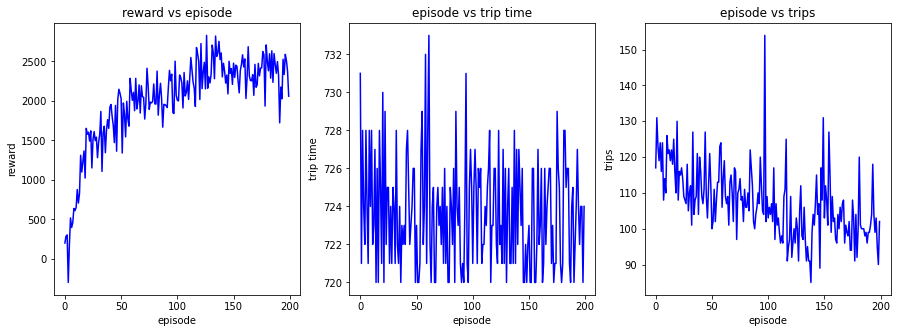

In [50]:
tracked_data_array = np.load('result.npy')
episodes = tracked_data_array[0]
rewards = tracked_data_array[1]
times = tracked_data_array[2]
trips = tracked_data_array[3]

plt.figure(figsize=(15,5))

plt.subplot(131)
plt.plot(episodes, rewards, 'b')
plt.xlabel('episode')
plt.ylabel('reward')
plt.title('reward vs episode')


plt.subplot(132)
plt.plot(episodes, times, 'b')
plt.xlabel('episode')
plt.ylabel('trip time')
plt.title('episode vs trip time')

plt.subplot(133)
plt.plot(episodes, trips, 'b')
plt.xlabel('episode')
plt.ylabel('trips')
plt.title('episode vs trips')

plt.show()

In [51]:
with open('state_action_sample.pickle', 'wb') as handle:
    pickle.dump(samples, handle, protocol=pickle.HIGHEST_PROTOCOL)

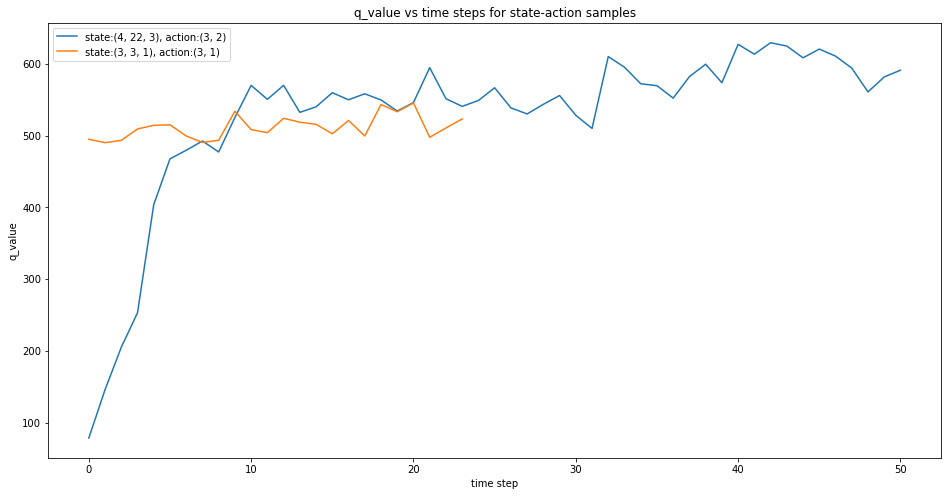

In [54]:
with open('state_action_sample.pickle', 'rb') as handle:
    state_action_sample = pickle.load(handle)

plt.figure(figsize=(16, 8))
for state_action,sample in filter(lambda elem: len(elem[1]) >= 5, state_action_sample.items()):
  plt.plot(sample, label='state:{}, action:{}'.format(state_action[0], state_action[1]))
    
plt.xlabel('time step')
plt.ylabel('q_value')
plt.title('q_value vs time steps for state-action samples')
plt.legend()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [ ]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

In [ ]:
plt.plot(time, epsilon)
plt.show()